In [1]:
import scanpy as sc
from tidyverse.dummy import *
from sctools import pipeline
from sctools.scplotting import kneeplot_split, recolor
from sctools.de import gene_expression_to_flat_df_NEW, scanpy_DE_to_dataframe_fast, get_de_genes
from crukiopy_release.datatools import read_metadata, fix_diagnosis, diagnosis_fix_dict
from crukiopy_release.colormaps import celltype_order_coarse_celltype, color_dict_diagnosis, cmap_subtypes
import scHCLpy.adata
import gc
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod
from cellprop_utils import plot_patient_diagnosis
from crukiopy_release.colormaps import color_dict_coarse_celltype
from sctools.scplotting import recolor
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
from crukiopy_release.celltype_mappings import annotate_coarse_celltype, annotate_epi_stroma_immune

set_matplotlib_formats('png')

Importing tidyverse


In [2]:
adata = sc.read_h5ad('/home/mstrasse/TB4/Aug2022_adata/Atlas/Eso_Atlas.h5ad')

# Stringent filtering!!
adata = adata[adata.obs.doublet_score<0.2]
adata = adata[adata.obs.percent_mito<0.1]

# fixing some diagnosis
adata = fix_diagnosis(adata)
# recolor(adata, 'diagnosis', color_dict_diagnosis)

adata = adata[adata.obs.diagnosis.isin(['NE', 'NS', 'M','D','T'])]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.obs` of view, copying.


In [3]:
df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(adata.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    if s in df_meta.index:
        df_meta.loc[s, 'diagnosis'] = d

In [4]:
adata.obs['tissue_split'] = annotate_epi_stroma_immune(adata, cluster_field='leiden')
adata.obs['tissue_split'] = pd.Categorical(adata.obs['tissue_split'])

Trying to set attribute `.obs` of view, copying.


In [5]:
adata.obs['celltype_split'] = annotate_coarse_celltype(adata, cluster_field='leiden')
adata.obs['celltype_split'] = adata.obs['celltype_split'].astype(str)

# warning, a little dangerous, since cluster 12 (dividing cells) has some squamous cells too
adata.obs.loc[adata.obs.celltype_split=="Epithelial cells",'celltype_split'] = 'Columnar Epithelium'
adata.obs.loc[adata.obs.celltype_split=="Macrophages",'celltype_split'] = 'Myeloid'
adata.obs.loc[adata.obs.leiden.isin(['20','18','17']),'celltype_split'] = 'Squamous Epithelium'
adata.obs.loc[adata.obs.leiden=="13", 'celltype_split'] = 'Myofibroblasts'

adata.obs['celltype_split'] = pd.Categorical(adata.obs['celltype_split'])

color_dict_coarse_celltype['Columnar Epithelium'] = color_dict_coarse_celltype['Epithelial cells']
color_dict_coarse_celltype['Squamous Epithelium'] = '#025b02'
color_dict_coarse_celltype['Myeloid'] = color_dict_coarse_celltype['Macrophages']
color_dict_coarse_celltype['Myofibroblasts'] = '#005eb7'
color_dict_coarse_celltype['Mast cells'] = '#b95657'
recolor(adata, 'celltype_split', color_dict_coarse_celltype)


/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'diagnosis' as categorical
... storing 'sample_diagnosis' as categorical


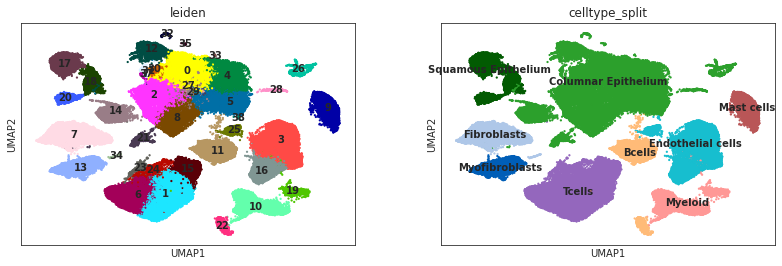

In [6]:
set_matplotlib_formats('png')
sc.pl.umap(adata, color=['leiden', 'celltype_split'], legend_loc='on data', size=20)

# proliferative proportion
Note: we have to redo the celltype split on the uncorrected data, since the dividing squamous cells clsuter with dividing columnar epi cells in the batch-corrected data


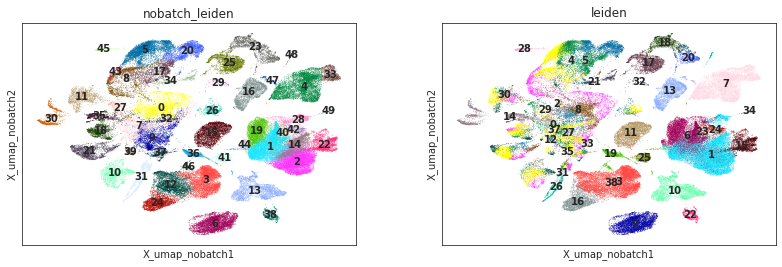

In [7]:
set_matplotlib_formats('png')
adata.obs['celltype_split'] = annotate_coarse_celltype(adata, cluster_field='nobatch_leiden')

adata.obs['celltype_split'] = adata.obs['celltype_split'].astype(str)

# some renames to get consistency acrsos the paper
adata.obs.loc[adata.obs.celltype_split=="Epithelial cells",'celltype_split'] = 'Columnar Epithelium'
adata.obs.loc[adata.obs.celltype_split=="Macrophages",'celltype_split'] = 'Myeloid'

# annotatinh squamous, myofib, neutrophils
adata.obs.loc[adata.obs.nobatch_leiden.isin(['25','23']),'celltype_split'] = 'Squamous Epithelium'
adata.obs.loc[adata.obs.leiden=="13", 'celltype_split'] = 'Myofibroblasts'
adata.obs.loc[adata.obs.nobatch_leiden.isin(['36']),'celltype_split'] = 'Neutrophils'

adata.obs['celltype_split'] = pd.Categorical(adata.obs['celltype_split'])


color_dict_coarse_celltype['Columnar Epithelium'] = color_dict_coarse_celltype['Epithelial cells']
color_dict_coarse_celltype['Squamous Epithelium'] = '#025b02'
color_dict_coarse_celltype['Myeloid'] = color_dict_coarse_celltype['Macrophages']
color_dict_coarse_celltype['Myofibroblasts'] = '#005eb7'
color_dict_coarse_celltype['Mast cells'] = '#b95657'
recolor(adata, 'celltype_split', color_dict_coarse_celltype)

sc.pl.embedding(adata, basis='X_umap_nobatch', color=['nobatch_leiden', 'leiden'], legend_loc='on data')

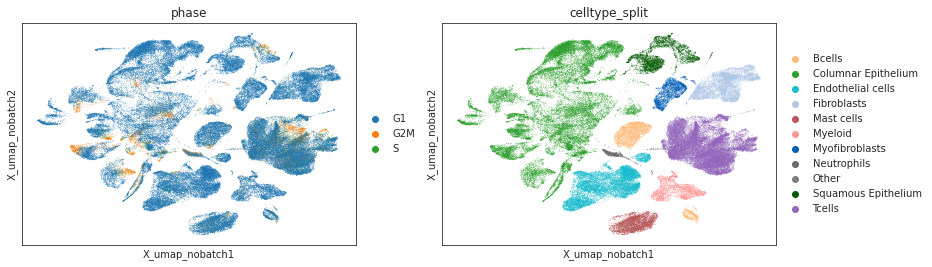

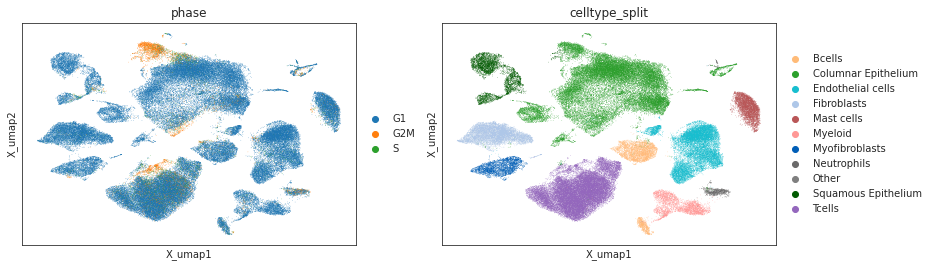

In [8]:
sc.pl.embedding(adata, basis='X_umap_nobatch', color=['phase', 'celltype_split'])
sc.pl.embedding(adata, basis='X_umap', color=['phase', 'celltype_split'])

## fraction of proliferative cells across all patients

In [9]:
### patient specific

In [10]:
from scipy.stats import beta
from sctools.annotations import get_cellcycle_genes

def binomial_proportions_estimator(n_success, n_fails):
    posterior = beta(1+n_success, 1+ n_fails)  # prob of being G1 vs being S,G2M
    q5, q50, q95 = posterior.ppf([0.05, 0.5, 0.95])    
    the_mean = posterior.mean()
    
    return {'q5': q5, 'q50': q50, 'q95': q95, 'mean': the_mean}
    
def estimate_cc_fractions(adata, covariates, method):
    """
    covariates: how to group the cells: In each group we calculate the fraction of cycling cells
    """
    
    assert method in ['cc_score', 'KI67']
    
#     s_genes, g2m_genes = get_cellcycle_genes()
#     s_genes = [_ for _ in s_genes if _ in adata.var_names]
#     g2m_genes = [_ for _ in g2m_genes if _ in adata.var_names]
    
    results = []
    for cov_values, df in adata.obs.groupby(covariates):
        
        adata_tmp = adata[df.index].copy()
#         sc.tl.score_genes_cell_cycle(adata_tmp, s_genes, g2m_genes)
        
        if method == 'cc_score':
            freqs = adata_tmp.obs.phase.value_counts().to_dict()
            freqs = collections.defaultdict(int, freqs)
            freqs['n_total'] = sum(freqs.values())
            # estimate proportions
            posterior_quantiles = binomial_proportions_estimator(freqs['G1'], freqs['G2M']+freqs['S'])


        elif method == 'KI67':
            adata_tmp.obs['tmp_phase'] = adata_tmp[:, 'TOP2A'].X.A
            adata_tmp.obs['tmp_phase'] = adata_tmp.obs['tmp_phase'].apply(lambda x: 'G1' if x==0 else 'S')
            freqs = adata_tmp.obs.tmp_phase.value_counts().to_dict()
            freqs = collections.defaultdict(int, freqs)
            freqs['n_total'] = sum(freqs.values())
    
            posterior_quantiles = binomial_proportions_estimator(freqs['G1'], freqs['G2M']+freqs['S'])

        else:
            raise ValueError('')
        for value, c in zip(cov_values, covariates):
            freqs[c] = value   
        
        freqs.update(posterior_quantiles)

        results.append(freqs)
    results = pd.DataFrame(results)

    return results

In [11]:
results = estimate_cc_fractions(adata, ['diagnosis', 'patient', 'celltype_split'], method='cc_score')
results.diagnosis = pd.Categorical(results.diagnosis, categories=['NE','NS','M','D','T'])

# filter out D
results = results.query('diagnosis!="D"')
# mreging the squamous and columanr epithelium
results= results.replace({'celltype_split': {'Squamous Epithelium': 'Epithelial cells', 'Columnar Epithelium': 'Epithelial cells'}})

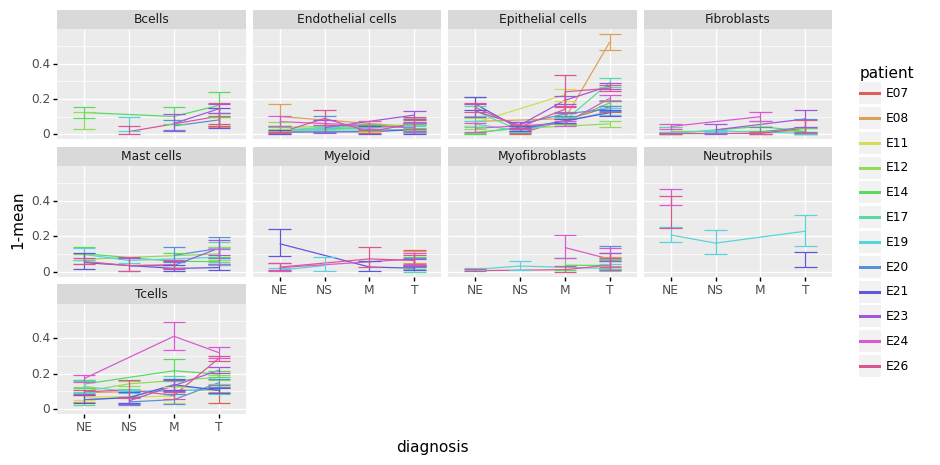

<ggplot: (8733246357221)>

In [12]:
pn.ggplot(results.query('celltype_split!="Other" and n_total>50'), 
          pn.aes(y='1-mean', x='diagnosis', color='patient', group='patient', ymin='1-q5', ymax='1-q95'))\
+ pn.facet_wrap('celltype_split', ncol=4)+ pn.geom_line() + pn.geom_errorbar() + pn.theme(figure_size=(10,5)) #+pn.lims(y=[0,0.5])

In [13]:
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

def do_glm_on_proliferation(df):
    """
    this does the regression per patient
    """
    assert len(df.celltype_split==1)
    
    df_regression = df[['G1', 'n_total', 'diagnosis', 'patient',]]
    df_regression['diagnosis'] = pd.Categorical(df_regression['diagnosis'], categories=['NE', 'NS', 'M', 'D','T'])
    df_regression['patient'] = pd.Categorical(df_regression['patient'])
    pandas2ri.activate()
    ro.globalenv['df'] = df_regression

    ro.r('df$diagnosis = factor(df$diagnosis, ordered=FALSE, levels=c("NE","NS","M", "T"))')  # optinoal: ordered encoding -> polynomial lm
    ro.r('res = glm( cbind(n_total-G1, G1) ~ diagnosis + patient, family=binomial(link = "logit"), data=df)');

    #resulting coeffs into pandas
    coeff_names = list(ro.r('rownames(summary(res)$coefficients)'))
    coeff_cols = list(ro.r('colnames(summary(res)$coefficients)'))
    coeffs = ro.r('summary(res)$coefficients')
    df_coeff = pd.DataFrame(coeffs, index=coeff_names, columns=coeff_cols)
    
    ypred = ro.r('res$fitted.values')
    df_regression['ypred'] = ypred
    
    return df_coeff, df_regression

In [16]:
df_regression_all = []
df_sign_coeffs = []

celltypes_to_consider = [
    'Myeloid', 
    'Fibroblasts', 
    'Bcells', 
    'Epithelial cells', 
#     'Squamous Epithelium', 
#     'Columnar Epithelium', 
     'Myofibroblasts', 
    'Tcells', 
    'Endothelial cells',
    'Mast cells']


for celltype in celltypes_to_consider:
    df_coeff, df_regression = do_glm_on_proliferation(results.query('celltype_split==@celltype and n_total>50'))
    print(celltype)
    
#     diagnoses_to_consider = ['NE','NS','M']
    diagnoses_to_consider = ['NS','M','T']
    
    # add the quantiles for viz
    df_quantile = pd.DataFrame([binomial_proportions_estimator(s, f) for s,f in zip(df_regression['n_total']-df_regression['G1'], df_regression['G1'])])
    df_quantile.index = df_regression.index
    df_regression = pd.concat([df_regression, df_quantile], axis=1)
    
    df_regression['celltype'] = celltype
    df_regression_all.append(df_regression)
    
    # store the pvalues for later
    _tmp = [{'celltype': celltype,
      'diagnosis': diag,  
      'coeff': df_coeff.loc[f'diagnosis{diag}']['Estimate'],  
      'pvalue': df_coeff.loc[f'diagnosis{diag}']['Pr(>|z|)']} for diag in diagnoses_to_consider]
    df_sign_coeffs.extend(_tmp) 
    
df_sign_coeffs = pd.DataFrame(df_sign_coeffs)

# from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests
df_sign_coeffs['qvalue'] = multipletests(df_sign_coeffs.pvalue, method='fdr_bh')[1]

df_regression_all = pd.concat(df_regression_all)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mstrasse/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mstrasse/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Myeloid
Fibroblasts
Bcells
Epithelial cells
Myofibroblasts
Tcells
Endothelial cells
Mast cells


In [18]:
p = pn.ggplot(df_regression_all, 
          pn.aes(y='(n_total-G1)/n_total', x='diagnosis', color='patient', group='patient',  ymin='q5', ymax='q95')) + \
    pn.geom_point() + pn.geom_line(size=1) + pn.theme(figure_size=(7,7)) + pn.labs(y='Fraction of dividing cells')\
    + pn.facet_wrap('celltype')  + pn.geom_errorbar(alpha=0.5) + pn.theme()

p.save('/tmp/proliferation.svg')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 7 x 7 in image.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /tmp/proliferation.svg


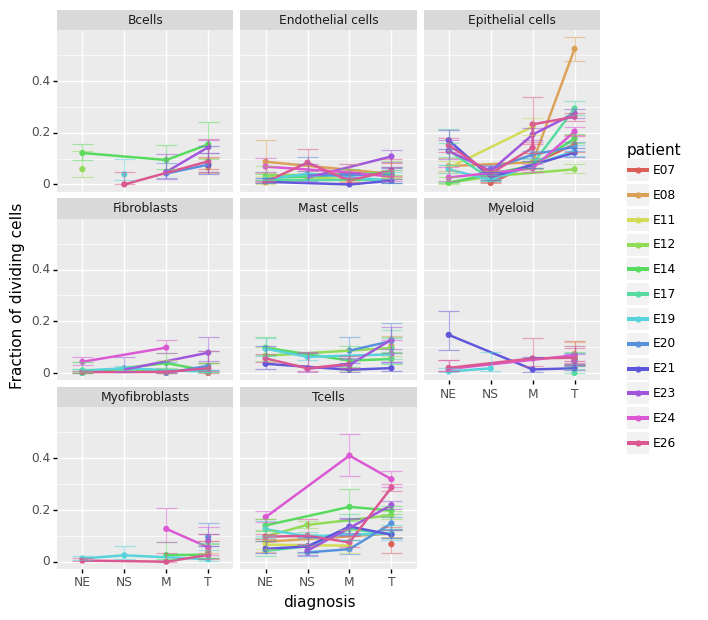

<ggplot: (8735088471181)>

In [36]:
pn.ggplot(df_regression_all, 
          pn.aes(y='(n_total-G1)/n_total', x='diagnosis', color='patient', group='patient',  ymin='q5', ymax='q95')) + \
    pn.geom_point() + pn.geom_line(size=1) + pn.theme(figure_size=(7,7)) + pn.labs(y='Fraction of dividing cells')\
    + pn.facet_wrap('celltype')  + pn.geom_errorbar(alpha=0.5) + pn.theme()

In [37]:
df_sign_coeffs.diagnosis = pd.Categorical(df_sign_coeffs.diagnosis, ['NE', 'NS','M','T'])
df_sign_coeffs.query('qvalue<0.05')

,celltype,diagnosis,coeff,pvalue,qvalue
4,Fibroblasts,M,0.842147,8.077562e-04,2.423269e-03
9,Epithelial cells,NS,-0.758283,5.455893e-15,4.364715e-14
10,Epithelial cells,M,0.507681,2.410372e-12,1.446223e-11
11,Epithelial cells,T,1.322975,5.864744e-86,1.407539e-84
15,Tcells,NS,0.322243,3.502578e-05,1.200884e-04
16,Tcells,M,0.446293,2.946158e-07,1.414156e-06
17,Tcells,T,0.921633,3.813361e-68,4.576033e-67
18,Endothelial cells,NS,0.755375,1.948829e-05,7.795317e-05
20,Endothelial cells,T,0.534653,2.705357e-03,7.214285e-03
21,Mast cells,NS,-0.590877,1.431101e-02,3.122403e-02


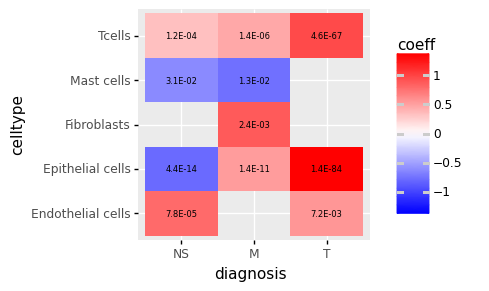

<ggplot: (8735088012533)>

In [38]:
df_sign_coeffs['qvalue_str'] = df_sign_coeffs.qvalue.apply(lambda x: f'{x:.1E}')
pn.ggplot(df_sign_coeffs.query('qvalue<0.051'), pn.aes(x='diagnosis', y='celltype', fill='coeff', label='qvalue_str')) + pn.geom_tile() + pn.geom_text(size=6)\
+ pn.scale_fill_cmap('bwr', limits=[-1.3, 1.3]) + pn.theme(figure_size=(3,3))

### KI67 method

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


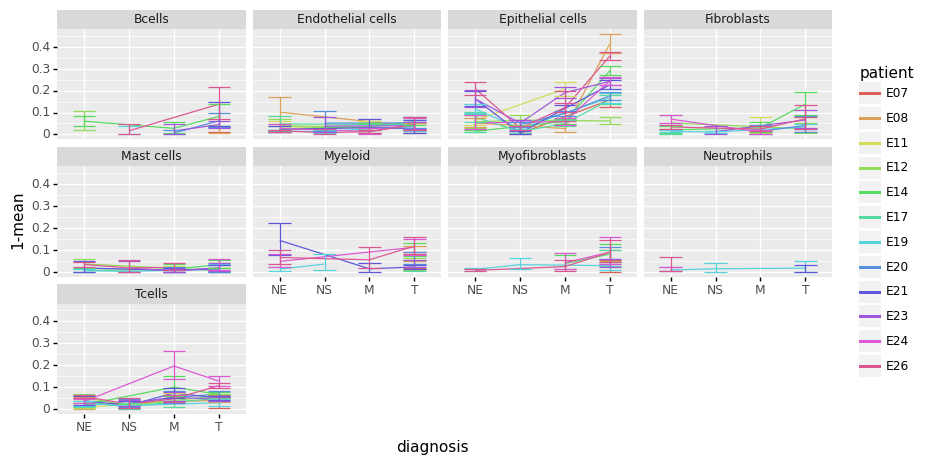

<ggplot: (8734862972997)>

In [40]:
results = estimate_cc_fractions(adata, ['diagnosis', 'patient', 'celltype_split'], method='KI67')
results.diagnosis = pd.Categorical(results.diagnosis, categories=['NE','NS','M','D','T'])

# mreging the squamous and columanr epithelium
results= results.replace({'celltype_split': {'Squamous Epithelium': 'Epithelial cells', 'Columnar Epithelium': 'Epithelial cells'}})

# filter out D
results = results.query('diagnosis!="D"')

pn.ggplot(results.query('celltype_split!="Other" and n_total>50'), 
          pn.aes(y='1-mean', x='diagnosis', color='patient', group='patient', ymin='1-q5', ymax='1-q95'))\
+ pn.facet_wrap('celltype_split', ncol=4,)+ pn.geom_line() + pn.geom_errorbar() + pn.theme(figure_size=(10,5)) #+pn.lims(y=[0,0.5])

### Pooling patients 

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


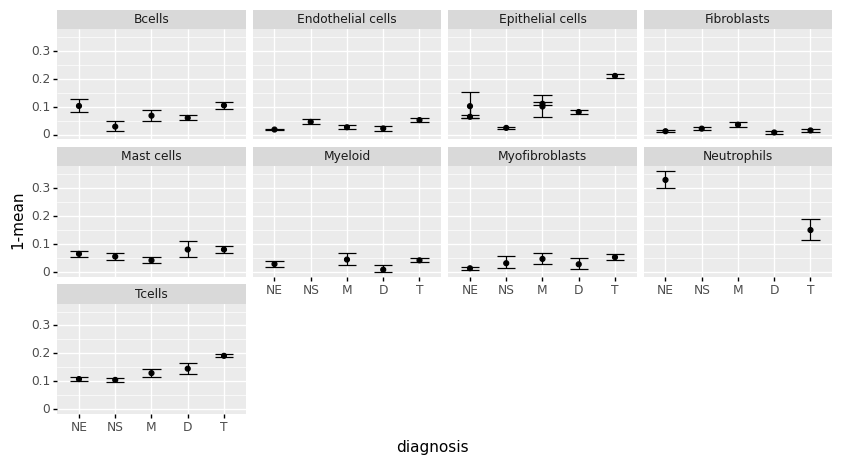

<ggplot: (8735087303385)>

In [41]:
results = estimate_cc_fractions(adata, ['diagnosis', 'celltype_split'], method='cc_score')
# mreging the squamous and columanr epithelium
results= results.replace({'celltype_split': {'Squamous Epithelium': 'Epithelial cells', 'Columnar Epithelium': 'Epithelial cells'}})

results.diagnosis = pd.Categorical(results.diagnosis, categories=['NE','NS','M','D','T'])
pn.ggplot(results.query('celltype_split!="Other" and n_total>100'), 
          pn.aes(y='1-mean', x='diagnosis', ymin='1-q5', ymax='1-q95'))\
+ pn.facet_wrap('celltype_split', ncol=4)+ pn.geom_line() + pn.geom_errorbar() + pn.geom_point()  + pn.theme(figure_size=(10,5)) #+pn.lims(y=[0,0.5])